# QF620 Part II

Prathmesh Desai  
Rahul Sreeram  
Srivatsa Mitragotri  
Nandini Agarwal  
Harshita Sachdev  

# Import Library

In [4]:
import pandas as pd
import numpy as np

import datetime as dt

import matplotlib.pylab as plt
import seaborn as sns

import array
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import norm
from scipy.optimize import brentq,fsolve
from scipy.optimize import least_squares
from scipy import interpolate

# Black-Scholes Model

In [6]:
# Black-Scholes Model
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# Bachelier Model

In [8]:
# Bachelier Model
def BachelierCall(S, K, r, sigma, T):
    d = (S-K) / (S*sigma*np.sqrt(T))
    disc = np.exp(-r*T)
    return disc*((S-K)*norm.cdf(d)+S*sigma*np.sqrt(T)*norm.pdf(d))

def BachelierPut(S, K, r, sigma, T):
    d = (S-K) / (S*sigma*np.sqrt(T))
    disc = np.exp(-r*T)
    return disc*((K-S)*norm.cdf(-d)+S*sigma*np.sqrt(T)*norm.pdf(-d))

# Import SPX Data

In [10]:
# Discount Rate
rate_df = pd.read_csv('zero_rates_20201201.csv')

# SPX General Data
spx_df = pd.read_csv('SPX_options.csv')
spx_df['strike_price'] = spx_df['strike_price']/1000
spx_df['mid_price'] = (spx_df['best_bid'] + spx_df['best_offer'])/2

# SPX Maturity Data
spx1 = spx_df[(spx_df.exdate == 20201218)]
spx2 = spx_df[(spx_df.exdate == 20210115)]
spx3 = spx_df[(spx_df.exdate == 20210219)]

# Parameter

In [12]:
# Time To Maturity
today = dt.date(2020, 12, 1)
exdate1 = dt.date(2020, 12, 18)
exdate2 = dt.date(2021, 1, 15)
exdate3 = dt.date(2021, 2, 19)
T1 = (exdate1-today).days/365.0
T2 = (exdate2-today).days/365.0
T3 = (exdate3-today).days/365.0

# Discount Rate Interpolation
x = rate_df['days']
y = rate_df['rate']
f = interpolate.interp1d(x,y)
r1 = f(T1*365)/100
r2 = f(T2*365)/100
r3 = f(T3*365)/100

# Underlying Value & ATM Strike Price
S = 3662.45
K = 3660

# Beta Parameter (Displaced-Diffusion Model)
beta1 = 0.8
beta2 = 0.6
beta3 = 0.4
beta4 = 0.2

# Steps Parameter (American Options)
steps = 20

# ATM Implied Volatility

In [14]:
# Implied European Options Volatility Model
def impliedCallVolatility(S, K, r, price, T):
    try:
        impliedVol = brentq(lambda x: price -
                        BlackScholesCall(S, K, r, x, T),
                        1e-6, 10)
    except Exception:
        impliedVol = np.nan
    return impliedVol

def impliedPutVolatility(S, K, r, price, T):
    try:
        impliedVol = brentq(lambda x: price -
                        BlackScholesPut(S, K, r, x, T),
                        1e-6, 10)
    except Exception:
        impliedVol = np.nan
    return impliedVol

In [15]:
## At The Money Volatility (ExDate: 2020/12/18)
atm_call1 = spx1[(spx1.strike_price == K)]
atm_call1 = atm_call1[(atm_call1.cp_flag == "C")]
atm_put1 = spx1[(spx1.strike_price == K)]
atm_put1 = atm_put1[(atm_put1.cp_flag == "P")]
sigma_call1 = impliedCallVolatility(S, K, r1 , atm_call1['mid_price'].iloc[0], T1)
sigma_put1 = impliedPutVolatility(S, K, r1, atm_put1['mid_price'].iloc[0], T1)
sigma1 = (sigma_call1 + sigma_put1)/2

## At The Money Volatility (ExDate: 2021/1/15)
atm_call2 = spx2[(spx2.strike_price == K)]
atm_call2 = atm_call2[(atm_call2.cp_flag == "C")]
atm_put2 = spx2[(spx2.strike_price == K)]
atm_put2 = atm_put2[(atm_put2.cp_flag == "P")]
sigma_call2 = impliedCallVolatility(S, K, r2 , atm_call2['mid_price'].iloc[0], T2)
sigma_put2 = impliedPutVolatility(S, K, r2, atm_put2['mid_price'].iloc[0], T2)
sigma2 = (sigma_call2 + sigma_put2)/2

## At The Money Volatility (ExDate: 2021/2/19)
atm_call3 = spx3[(spx3.strike_price == K)]
atm_call3 = atm_call3[(atm_call3.cp_flag == "C")]
atm_put3 = spx3[(spx3.strike_price == K)]
atm_put3 = atm_put3[(atm_put3.cp_flag == "P")]
sigma_call3 = impliedCallVolatility(S, K, r3 , atm_call3['mid_price'].iloc[0], T3)
sigma_put3 = impliedPutVolatility(S, K, r3, atm_put3['mid_price'].iloc[0], T3)
sigma3 = (sigma_call3 + sigma_put3)/2

In [16]:
sigma1,sigma2,sigma3

(0.17509857045855076, 0.18537188428716644, 0.19097327268194084)

# Displaced-Diffusion Volatility

In [18]:
# Displaced-Diffusion Model
def DisplacedDiffusionCall(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    return np.exp(-r*T)*(F/beta*norm.cdf(c1) - ((1-beta)/beta*F + K)*norm.cdf(c2))

def DisplacedDiffusionPut(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    return np.exp(-r*T)*(((1-beta)/beta*F + K)*norm.cdf(-c2) - F/beta*norm.cdf(-c1))

In [19]:
# Displaced Diffusion Volatility (exdate1)
spx_call1 = spx1[(spx1.cp_flag == "C")].reset_index(drop=True)
spx_put1 = spx1[(spx1.cp_flag == "P")].reset_index(drop=True)
strike1 = spx_put1["strike_price"].values

summary1 = []
for i in range(len(spx_put1.index)):
    K = strike1[i]
    if K <= 3660:
        impliedvol_market = impliedPutVolatility(S, K, r1, spx_put1['mid_price'][i], T1)

        price_lognormal = BlackScholesPut(S, K, r1, sigma1, T1)
        impliedvol_lognormal = impliedPutVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierPut(S, K, r1, sigma1, T1)
        impliedvol_normal = impliedPutVolatility(S, K, r1, price_normal, T1)
    
        price_dd1 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r1, price_dd1, T1)
        
        price_dd2 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r1, price_dd2, T1)
        
        price_dd3 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r1, price_dd3, T1)
        
        price_dd4 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r1, price_dd4, T1)

    elif K > 3660:
        impliedvol_market = impliedCallVolatility(S, K, r1, spx_call1['mid_price'][i], T1)

        price_lognormal = BlackScholesCall(S, K, r1, sigma1, T1)
        impliedvol_lognormal = impliedCallVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierCall(S, K, r1, sigma1, T1)
        impliedvol_normal = impliedCallVolatility(S, K, r1, price_normal, T1)
       
        price_dd1 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r1, price_dd1, T1)
        
        price_dd2 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r1, price_dd2, T1)
        
        price_dd3 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r1, price_dd3, T1)
        
        price_dd4 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r1, price_dd4, T1)
        
    summary1.append([K, 
                     impliedvol_market, 
                     impliedvol_lognormal,
                     impliedvol_normal, 
                     impliedvol_dd1,
                     impliedvol_dd2,
                     impliedvol_dd3,
                     impliedvol_dd4,])
    
dd_1 = pd.DataFrame(summary1, columns=['strike', 
                                       'impliedvol_market',
                                       'impliedvol_lognormal', 
                                       'impliedvol_normal', 
                                       'impliedvol_dd1',
                                       'impliedvol_dd2',
                                       'impliedvol_dd3',
                                       'impliedvol_dd4'])

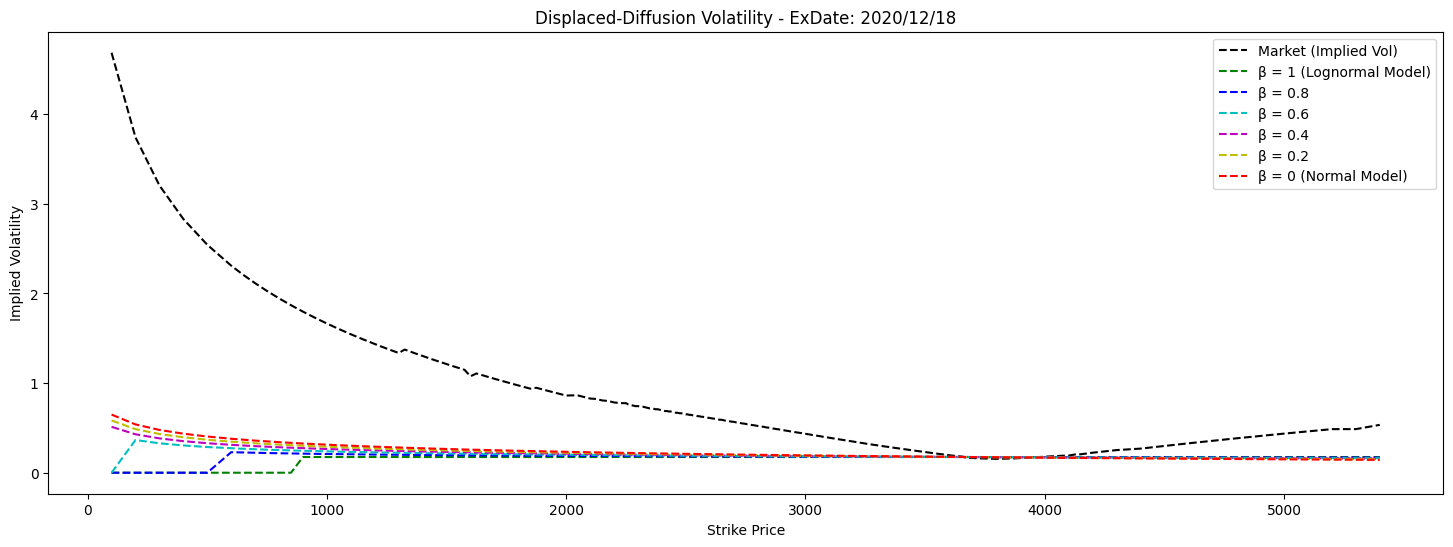

In [20]:
plt.figure(figsize=(18 , 6))
plt.plot(dd_1['strike'],dd_1['impliedvol_market'],'k--',label='Market (Implied Vol)')
plt.plot(dd_1['strike'],dd_1['impliedvol_lognormal'],'g--',label='β = 1 (Lognormal Model)')
plt.plot(dd_1['strike'],dd_1['impliedvol_dd1'],'b--',label='β = 0.8')
plt.plot(dd_1['strike'],dd_1['impliedvol_dd2'],'c--',label='β = 0.6')
plt.plot(dd_1['strike'],dd_1['impliedvol_dd3'],'m--',label='β = 0.4')
plt.plot(dd_1['strike'],dd_1['impliedvol_dd4'],'y--',label='β = 0.2')
plt.plot(dd_1['strike'],dd_1['impliedvol_normal'],'r--',label='β = 0 (Normal Model)')

plt.title('Displaced-Diffusion Volatility - ExDate: 2020/12/18', color = 'k')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')

plt.legend()
plt.show()

In [21]:
# Displaced Diffusion Volatility (exdate2)
spx_call2 = spx2[(spx2.cp_flag == "C")].reset_index(drop=True)
spx_put2 = spx2[(spx2.cp_flag == "P")].reset_index(drop=True)
strike2 = spx_put2["strike_price"].values

summary2 = []
for i in range(len(spx_put2.index)):
    K = strike2[i]
    if K <= 3660:
        impliedvol_market = impliedPutVolatility(S, K, r2, spx_put2['mid_price'][i], T2)

        price_lognormal = BlackScholesPut(S, K, r2, sigma2, T2)
        impliedvol_lognormal = impliedPutVolatility(S, K, r2, price_lognormal, T2)

        price_normal = BachelierPut(S, K, r2, sigma2, T2)
        impliedvol_normal = impliedPutVolatility(S, K, r2, price_normal, T2)
    
        price_dd1 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r2, price_dd1, T2)
        
        price_dd2 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r2, price_dd2, T2)
        
        price_dd3 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r2, price_dd3, T2)
        
        price_dd4 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r2, price_dd4, T2)

    elif K > 3660:
        impliedvol_market = impliedCallVolatility(S, K, r2, spx_call2['mid_price'][i], T2)

        price_lognormal = BlackScholesCall(S, K, r2, sigma2, T2)
        impliedvol_lognormal = impliedCallVolatility(S, K, r2, price_lognormal, T2)

        price_normal = BachelierCall(S, K, r2, sigma2, T2)
        impliedvol_normal = impliedCallVolatility(S, K, r2, price_normal, T2)
       
        price_dd1 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r2, price_dd1, T2)
        
        price_dd2 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r2, price_dd2, T2)
        
        price_dd3 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r2, price_dd3, T2)
        
        price_dd4 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r2, price_dd4, T2)
        
    summary2.append([K, 
                     impliedvol_market, 
                     impliedvol_lognormal,
                     impliedvol_normal, 
                     impliedvol_dd1,
                     impliedvol_dd2,
                     impliedvol_dd3,
                     impliedvol_dd4,])
    
dd_2 = pd.DataFrame(summary2, columns=['strike', 
                                       'impliedvol_market',
                                       'impliedvol_lognormal', 
                                       'impliedvol_normal', 
                                       'impliedvol_dd1',
                                       'impliedvol_dd2',
                                       'impliedvol_dd3',
                                       'impliedvol_dd4'])

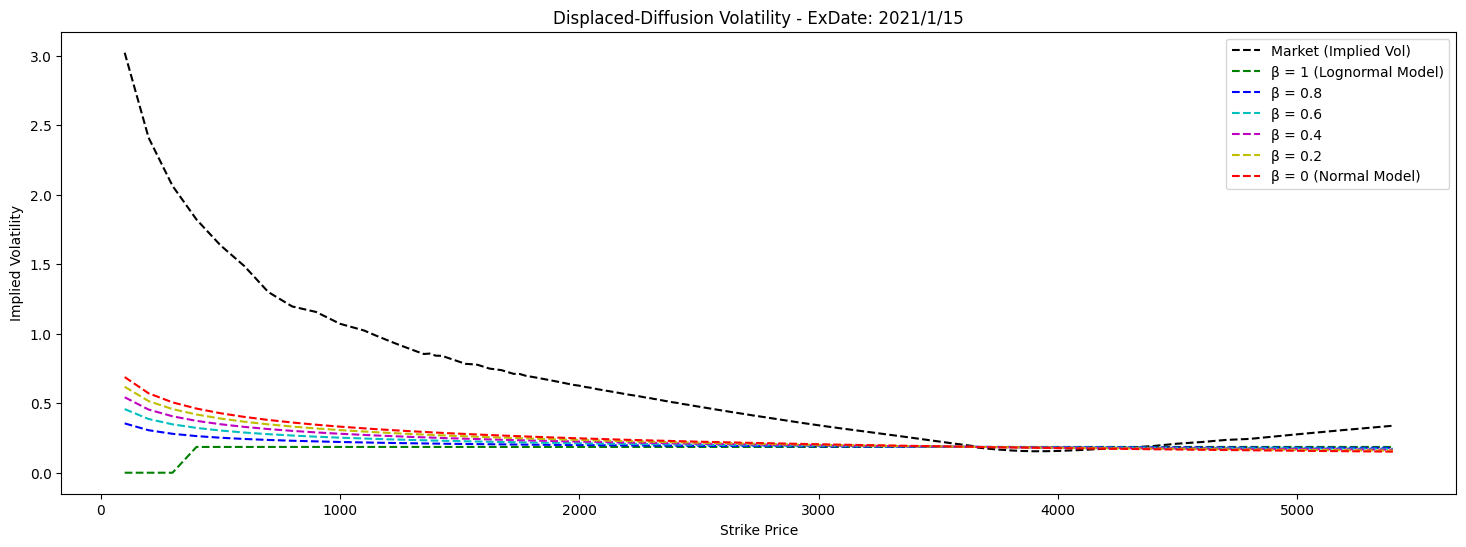

In [22]:
plt.figure(figsize=(18 , 6))
plt.plot(dd_2['strike'],dd_2['impliedvol_market'],'k--',label='Market (Implied Vol)')
plt.plot(dd_2['strike'],dd_2['impliedvol_lognormal'],'g--',label='β = 1 (Lognormal Model)')
plt.plot(dd_2['strike'],dd_2['impliedvol_dd1'],'b--',label='β = 0.8')
plt.plot(dd_2['strike'],dd_2['impliedvol_dd2'],'c--',label='β = 0.6')
plt.plot(dd_2['strike'],dd_2['impliedvol_dd3'],'m--',label='β = 0.4')
plt.plot(dd_2['strike'],dd_2['impliedvol_dd4'],'y--',label='β = 0.2')
plt.plot(dd_2['strike'],dd_2['impliedvol_normal'],'r--',label='β = 0 (Normal Model)')

plt.title('Displaced-Diffusion Volatility - ExDate: 2021/1/15', color = 'k')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')

plt.legend()
plt.show()

In [23]:
# Displaced Diffusion Volatility (exdate3)
spx_call3 = spx3[(spx3.cp_flag == "C")].reset_index(drop=True)
spx_put3 = spx3[(spx3.cp_flag == "P")].reset_index(drop=True)
strike3 = spx_put3["strike_price"].values

summary3 = []
for i in range(len(spx_put3.index)):
    K = strike3[i]
    if K <= 3660:
        impliedvol_market = impliedPutVolatility(S, K, r3, spx_put3['mid_price'][i], T3)

        price_lognormal = BlackScholesPut(S, K, r3, sigma3, T3)
        impliedvol_lognormal = impliedPutVolatility(S, K, r3, price_lognormal, T3)

        price_normal = BachelierPut(S, K, r3, sigma3, T3)
        impliedvol_normal = impliedPutVolatility(S, K, r3, price_normal, T3)
    
        price_dd1 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r3, price_dd1, T3)
        
        price_dd2 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r3, price_dd2, T3)
        
        price_dd3 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r3, price_dd3, T3)
        
        price_dd4 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r3, price_dd4, T3)

    elif K > 3660:
        impliedvol_market = impliedCallVolatility(S, K, r3, spx_call3['mid_price'][i], T3)

        price_lognormal = BlackScholesCall(S, K, r3, sigma3, T3)
        impliedvol_lognormal = impliedCallVolatility(S, K, r3, price_lognormal, T3)

        price_normal = BachelierCall(S, K, r3, sigma3, T3)
        impliedvol_normal = impliedCallVolatility(S, K, r3, price_normal, T3)
       
        price_dd1 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r3, price_dd1, T3)
        
        price_dd2 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r3, price_dd2, T3)
        
        price_dd3 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r3, price_dd3, T3)
        
        price_dd4 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r3, price_dd4, T3)
        
    summary3.append([K, 
                     impliedvol_market, 
                     impliedvol_lognormal,
                     impliedvol_normal, 
                     impliedvol_dd1,
                     impliedvol_dd2,
                     impliedvol_dd3,
                     impliedvol_dd4,])
    
dd_3 = pd.DataFrame(summary3, columns=['strike', 
                                       'impliedvol_market',
                                       'impliedvol_lognormal', 
                                       'impliedvol_normal', 
                                       'impliedvol_dd1',
                                       'impliedvol_dd2',
                                       'impliedvol_dd3',
                                       'impliedvol_dd4'])

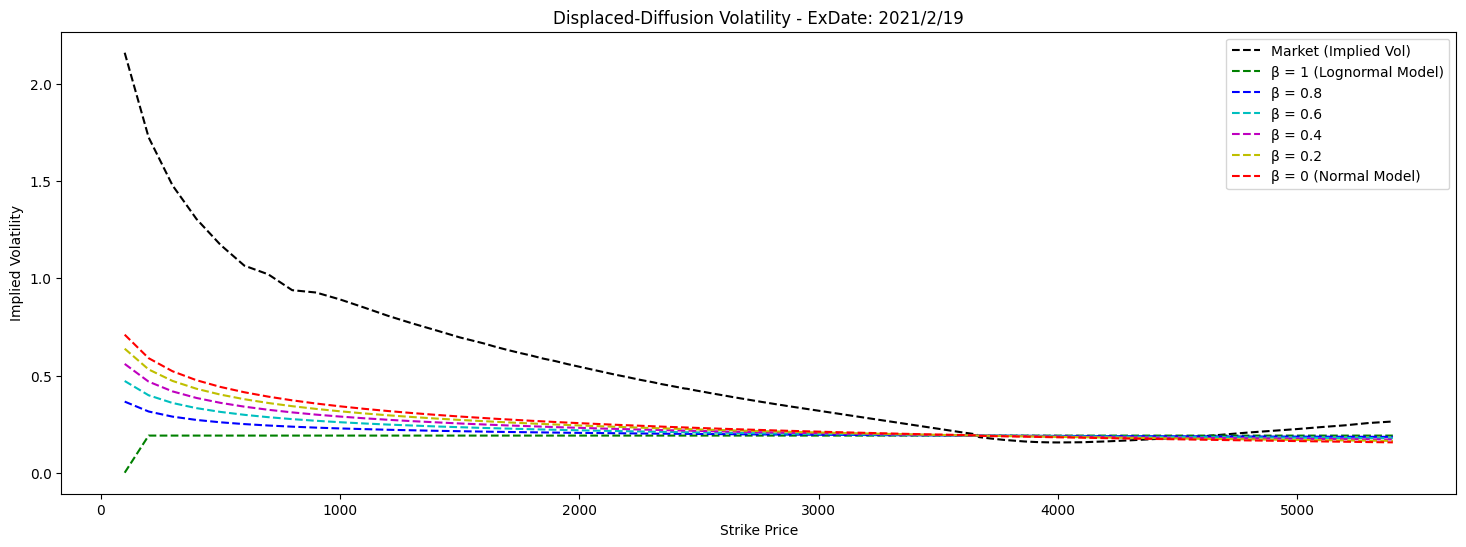

In [24]:
plt.figure(figsize=(18 , 6))
plt.plot(dd_3['strike'],dd_3['impliedvol_market'],'k--',label='Market (Implied Vol)')
plt.plot(dd_3['strike'],dd_3['impliedvol_lognormal'],'g--',label='β = 1 (Lognormal Model)')
plt.plot(dd_3['strike'],dd_3['impliedvol_dd1'],'b--',label='β = 0.8')
plt.plot(dd_3['strike'],dd_3['impliedvol_dd2'],'c--',label='β = 0.6')
plt.plot(dd_3['strike'],dd_3['impliedvol_dd3'],'m--',label='β = 0.4')
plt.plot(dd_3['strike'],dd_3['impliedvol_dd4'],'y--',label='β = 0.2')
plt.plot(dd_3['strike'],dd_3['impliedvol_normal'],'r--',label='β = 0 (Normal Model)')

plt.title('Displaced-Diffusion Volatility - ExDate: 2021/2/19', color = 'k')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')

plt.legend()
plt.show()

# Implied Volatility (Maturity Comparison)

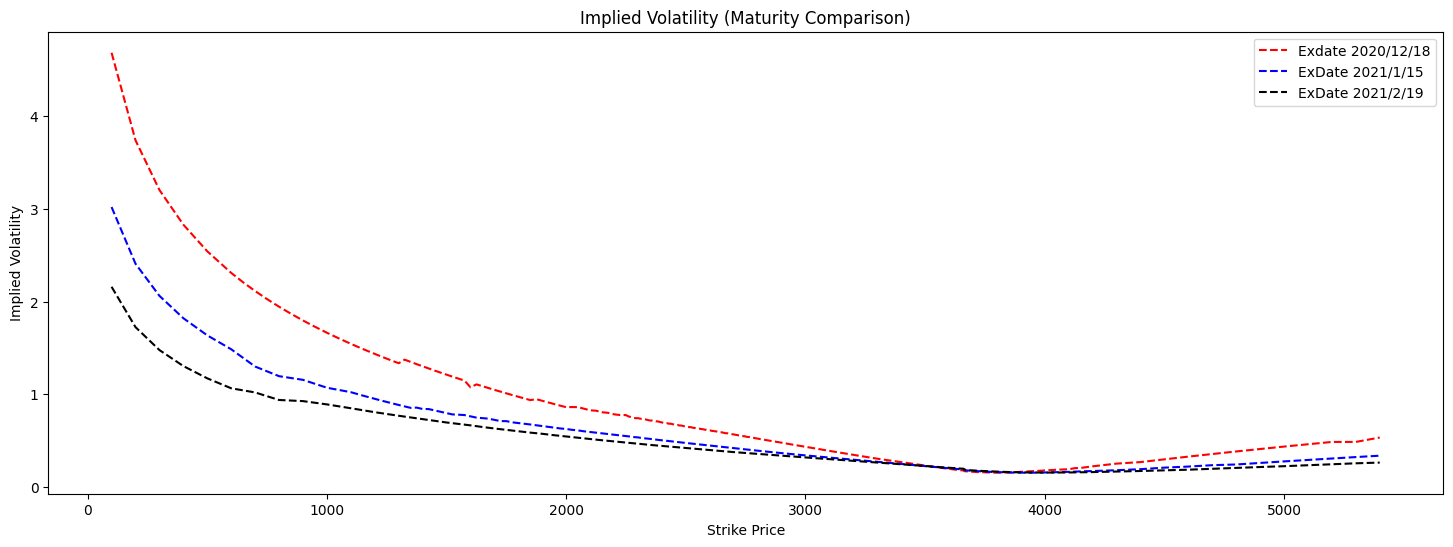

In [26]:
plt.figure(figsize=(18 , 6))
plt.plot(dd_1['strike'],dd_1['impliedvol_market'],'r--',label='Exdate 2020/12/18')
plt.plot(dd_2['strike'],dd_2['impliedvol_market'],'b--',label='ExDate 2021/1/15')
plt.plot(dd_3['strike'],dd_3['impliedvol_market'],'k--',label='ExDate 2021/2/19')

plt.title('Implied Volatility (Maturity Comparison)', color = 'k')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')

plt.legend()
plt.show()

# Import SPY Data

In [28]:
# SPY General Data
spy_df = pd.read_csv('SPY_options.csv')
spy_df['strike_price'] = spy_df['strike_price']/100
spy_df['mid_price'] = (spy_df['best_bid'] + spy_df['best_offer'])/0.2
S_A = 366.02*10

# SPY Maturity Data
spy1 = spy_df[(spy_df.exdate == 20201218)]
spy2 = spy_df[(spy_df.exdate == 20210115)]
spy3 = spy_df[(spy_df.exdate == 20210219)]

# Binomial Tree Model

In [30]:
# Binomial Tree Model
def american_put(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    uu = u*u
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up
    prices = array.array('d', (0 for i in range(0, steps+1)))
    prices[0] = S*pow(d, steps)

    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    put_values = array.array('d', (0 for i in range(0, steps+1)))

    for i in range(0, steps+1):
        put_values[i] = max(0.0, (K-prices[i]))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            put_values[i] = (p_up*put_values[i+1]+p_down*put_values[i])/R
            prices[i] = d*prices[i+1]
            put_values[i] = max(put_values[i], (K-prices[i]))
    return put_values[0]

def european_put(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    uu = u*u
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up
    prices = array.array('d', (0 for i in range(0, steps+1)))
    prices[0] = S*pow(d, steps)

    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    put_values = array.array('d', (0 for i in range(0, steps+1)))

    for i in range(0, steps+1):
        put_values[i] = max(0.0, (K-prices[i]))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            put_values[i] = (p_up*put_values[i+1]+p_down*put_values[i])/R
            prices[i] = d*prices[i+1]
    return put_values[0]

def american_call(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up

    prices = array.array('d', (0 for i in range(0, steps+1)))

    prices[0] = S*pow(d, steps)
    uu = u*u
    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    call_values = array.array('d', (0 for i in range(0, steps+1)))
    for i in range(0, steps+1):
        call_values[i] = max(0.0, (prices[i]-K))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            call_values[i] = (p_up*call_values[i+1]+p_down*call_values[i])/R
            prices[i] = d*prices[i+1]
            call_values[i] = max(call_values[i], 1.0*(prices[i]-K))

    return call_values[0]

def european_call(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up

    # price of underlying
    prices = array.array('d', (0 for i in range(0, steps+1)))

    # fill in the endnodes
    prices[0] = S*pow(d, steps)
    uu = u*u
    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    call_values = array.array('d', (0 for i in range(0, steps+1)))
    for i in range(0, steps+1):
        call_values[i] = max(0.0, (prices[i]-K))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            call_values[i] = (p_up*call_values[i+1]+p_down*call_values[i])/R
            prices[i] = d*prices[i+1]

    return call_values[0]

# American Options Implied Volatility

In [32]:
# American Options (exdate1)
spy_call1 = spy1[(spy1.cp_flag == "C")].reset_index(drop=True)
spy_put1 = spy1[(spy1.cp_flag == "P")].reset_index(drop=True)
strikeA1 = spy_put1["strike_price"].values

summaryA1_T = []
for i in range(len(spy_put1.index)):
    K = strikeA1[i]
    if K <= 3660:
        AP = american_put(S_A, K, r1, sigma1, T1, steps)
        EP = european_put(S_A, K, r1, sigma1, T1, steps)
        
    elif K > 3660:
        AP = american_call(S_A, K, r1, sigma1, T1, steps)
        EP = european_call(S_A, K, r1, sigma1, T1, steps)     
    
    summaryA1_T.append([K, 
                        AP,
                        EP])
    
A1_T = pd.DataFrame(summaryA1_T, columns=['strike', 
                                          'AP',
                                          'EP',])

A1_T['Premium'] = A1_T['AP'] - A1_T["EP"]

spy_put1['mid_price_stripped'] = spy_put1['mid_price'] - A1_T['Premium']
spy_call1['mid_price_stripped'] = spy_call1['mid_price'] - A1_T['Premium']

In [33]:
summaryA1 = []
for i in range(len(spy_put1.index)):
    K = strikeA1[i]
    if K <= 3660:
        impliedvol_market = impliedPutVolatility(S_A, K, r1, spy_put1['mid_price_stripped'][i], T1)
        
    elif K > 3660:
        impliedvol_market = impliedCallVolatility(S_A, K, r1, spy_call1['mid_price_stripped'][i], T1)
        
    summaryA1.append([K, 
                      impliedvol_market,])
    
A1 = pd.DataFrame(summaryA1, columns=['strike', 
                                      'impliedvol_market',])

In [34]:
# American Options (exdate2)
spy_call2 = spy2[(spy2.cp_flag == "C")].reset_index(drop=True)
spy_put2 = spy2[(spy2.cp_flag == "P")].reset_index(drop=True)
strikeA2 = spy_put2["strike_price"].values

summaryA2_T = []
for i in range(len(spy_put2.index)):
    K = strikeA2[i]
    if K <= 3660:
        AP = american_put(S_A, K, r2, sigma2, T2, steps)
        EP = european_put(S_A, K, r2, sigma2, T2, steps)

    elif K > 3660:
        AP = american_call(S_A, K, r2, sigma2, T2, steps)
        EP = european_call(S_A, K, r2, sigma2, T2, steps)
        
    summaryA2_T.append([K, 
                        AP,
                        EP])
    
A2_T = pd.DataFrame(summaryA2_T, columns=['strike', 
                                          'AP',
                                          'EP',])

A2_T['Premium'] = A2_T['AP'] - A2_T["EP"]

spy_put2['mid_price_stripped'] = spy_put2['mid_price'] - A2_T['Premium']
spy_call2['mid_price_stripped'] = spy_call2['mid_price'] - A2_T['Premium']

In [35]:
summaryA2 = []
for i in range(len(spy_put2.index)):
    K = strikeA2[i]
    if K <= 3660:
        impliedvol_market = impliedPutVolatility(S_A, K, r2, spy_put2['mid_price_stripped'][i], T2)
        
    elif K > 3660:
        impliedvol_market = impliedCallVolatility(S_A, K, r2, spy_call2['mid_price_stripped'][i], T2)
        
    summaryA2.append([K, 
                      impliedvol_market,])
    
A2 = pd.DataFrame(summaryA2, columns=['strike', 
                                      'impliedvol_market',])

In [36]:
# American Options (exdate3)
spy_call3 = spy3[(spy3.cp_flag == "C")].reset_index(drop=True)
spy_put3 = spy3[(spy3.cp_flag == "P")].reset_index(drop=True)
strikeA3 = spy_put3["strike_price"].values

summaryA3_T = []
for i in range(len(spy_put3.index)):
    K = strikeA2[i]
    if K <= 3660:
        AP = american_put(S_A, K, r3, sigma3, T3, steps)
        EP = european_put(S_A, K, r3, sigma3, T3, steps)
        
    elif K > 3660:
        AP = american_call(S_A, K, r3, sigma3, T3, steps)
        EP = european_call(S_A, K, r3, sigma3, T3, steps)
        
    summaryA3_T.append([K, 
                      AP,
                      EP])
    
A3_T = pd.DataFrame(summaryA3_T, columns=['strike', 
                                          'AP',
                                          'EP',])

A3_T['Premium'] = A3_T['AP'] - A3_T["EP"]

spy_put3['mid_price_stripped'] = spy_put3['mid_price'] - A3_T['Premium']
spy_call3['mid_price_stripped'] = spy_call3['mid_price'] - A3_T['Premium']

In [37]:
summaryA3 = []
for i in range(len(spy_put3.index)):
    K = strikeA3[i]
    if K <= 3660:
        impliedvol_market = impliedPutVolatility(S_A, K, r3, spy_put3['mid_price_stripped'][i], T3)
        
    elif K > 3660:
        impliedvol_market = impliedCallVolatility(S_A, K, r3, spy_call3['mid_price_stripped'][i], T3)
        
    summaryA3.append([K, 
                      impliedvol_market,])
    
A3 = pd.DataFrame(summaryA3, columns=['strike', 
                                      'impliedvol_market',])

# Implied Volatility (SPX-SPY Comparison)

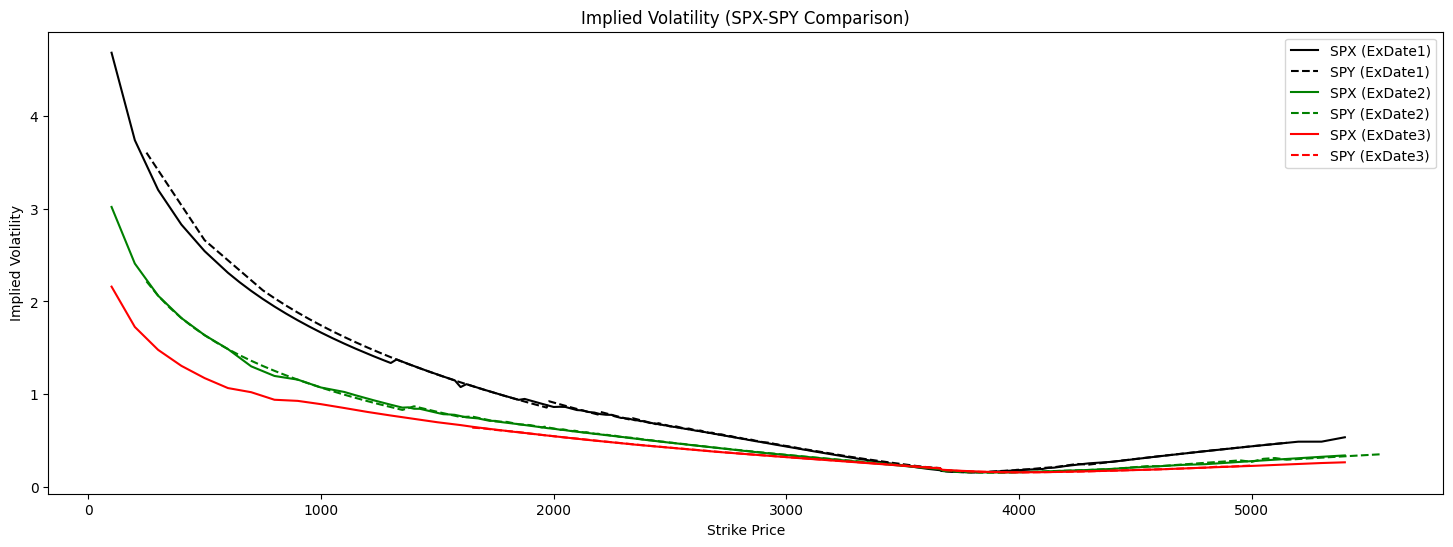

In [39]:
plt.figure(figsize=(18 , 6))
plt.plot(dd_1['strike'],dd_1['impliedvol_market'],'k',label='SPX (ExDate1)')
plt.plot(A1['strike'],A1['impliedvol_market'],'k--',label='SPY (ExDate1)')
plt.plot(dd_2['strike'],dd_2['impliedvol_market'],'g',label='SPX (ExDate2)')
plt.plot(A2['strike'],A2['impliedvol_market'],'g--',label='SPY (ExDate2)')
plt.plot(dd_3['strike'],dd_3['impliedvol_market'],'r',label='SPX (ExDate3)')
plt.plot(A3['strike'],A3['impliedvol_market'],'r--',label='SPY (ExDate3)')

plt.title('Implied Volatility (SPX-SPY Comparison)', color = 'k')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')

plt.legend()
plt.show()

# SABR Volatility

In [41]:
# SABR Calibration
def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2
    return err

# SABR Model
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

beta = 0.7

In [42]:
# SABR Volatility (exdate1)
F1 = np.exp(r1*T1)*S
initialGuess = [0.1, 0.1, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              dd_1['strike'],
                                              dd_1['impliedvol_market'],
                                              F1,
                                              T1),
                    initialGuess)

alpha1 = res.x[0]
rho1 = res.x[1]
nu1 = res.x[2]

SABR1 = []
for K in dd_1['strike']:
    SABR1.append(SABR(F1, K, T1, alpha1, beta, rho1, nu1))

print('SABR1 Calibration: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha1, beta, rho1, nu1))

SABR1 Calibration: alpha = 1.212, beta = 0.7, rho = -0.301, nu = 5.460


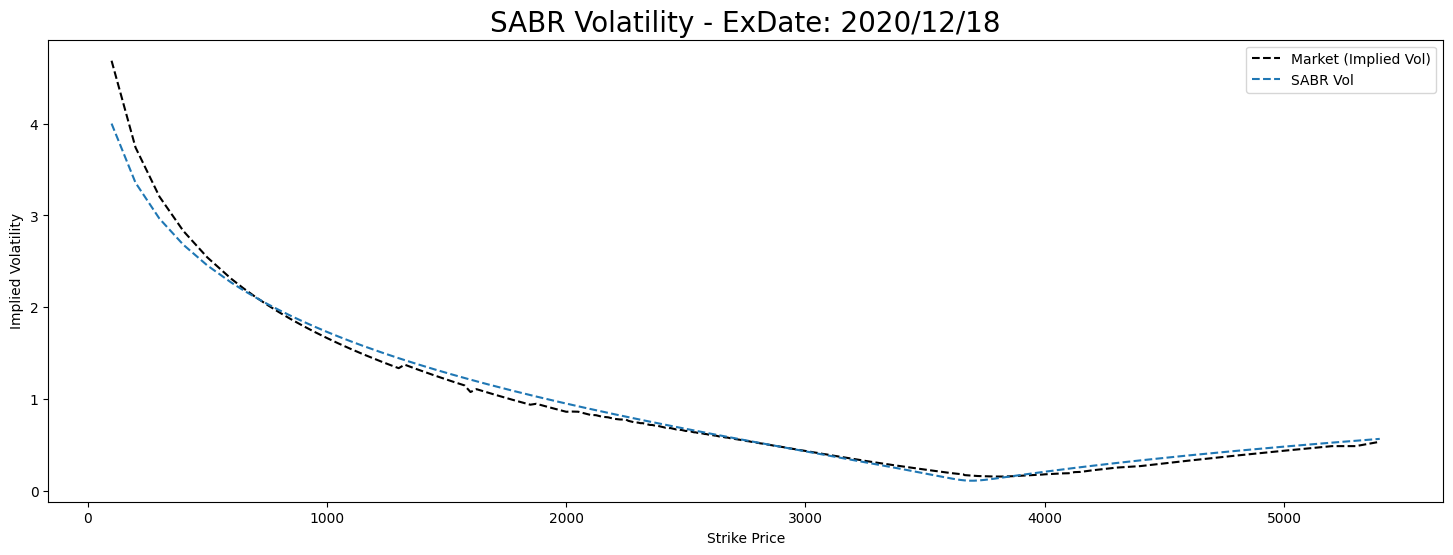

In [43]:
plt.figure(figsize=(18 , 6))
plt.plot(dd_1['strike'], dd_1['impliedvol_market'], 'k--', label='Market (Implied Vol)')
sns.lineplot(x = dd_1['strike'], y = SABR1, label = 'SABR Vol', linestyle = '--')


plt.title('SABR Volatility - ExDate: 2020/12/18', fontsize = 20)
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')

plt.legend()
plt.show()

In [44]:
# SABR Volatility (exdate2)
F2 = np.exp(r2*T2)*S
initialGuess = [0.1, 0.1, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              dd_2['strike'],
                                              dd_2['impliedvol_market'],
                                              F2,
                                              T2),
                    initialGuess)

alpha2 = res.x[0]
rho2 = res.x[1]
nu2 = res.x[2]

SABR2 = []
for K in dd_2['strike']:
    SABR2.append(SABR(F2, K, T2, alpha2, beta, rho2, nu2))

print('SABR2 Calibration: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha2, beta, rho2, nu2))

SABR2 Calibration: alpha = 1.817, beta = 0.7, rho = -0.404, nu = 2.790


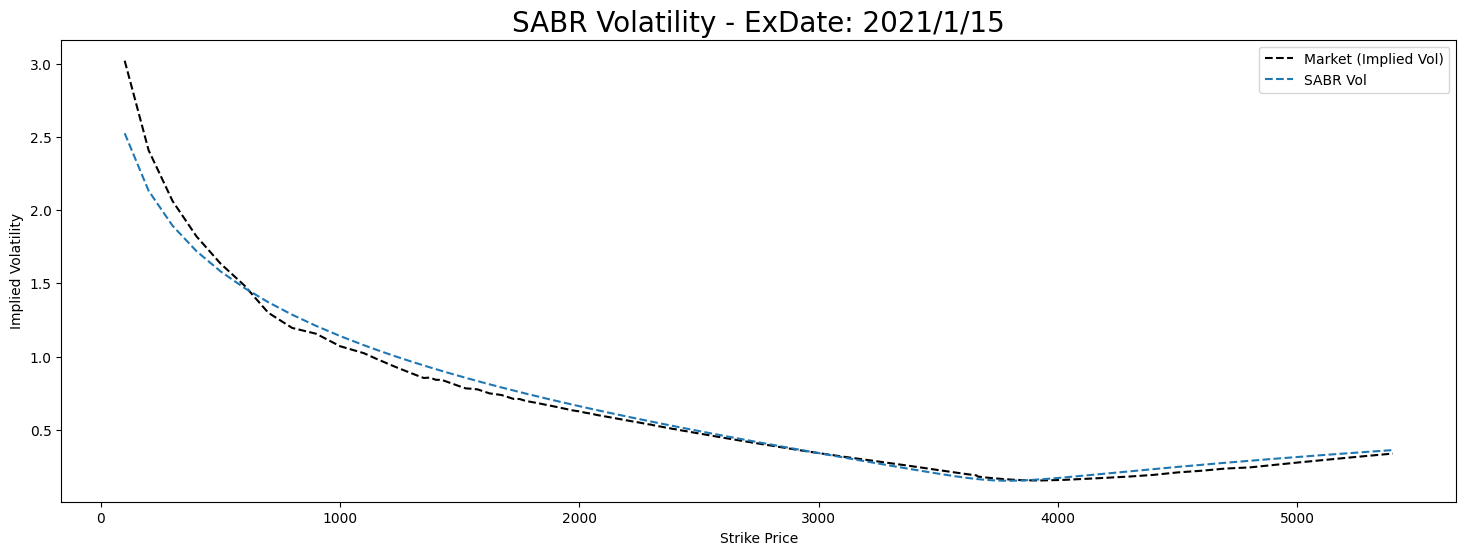

In [45]:
plt.figure(figsize=(18 , 6))
plt.plot(dd_2['strike'], dd_2['impliedvol_market'], 'k--', label='Market (Implied Vol)')
sns.lineplot(x = dd_2['strike'], y = SABR2, label = 'SABR Vol', linestyle = '--')


plt.title('SABR Volatility - ExDate: 2021/1/15', fontsize = 20)
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')

plt.legend()
plt.show()

In [46]:
# SABR Volatility (exdate3)
F3 = np.exp(r3*T3)*S
initialGuess = [0.1, 0.1, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              dd_3['strike'],
                                              dd_3['impliedvol_market'],
                                              F3,
                                              T3),
                    initialGuess)

alpha3 = res.x[0]
rho3 = res.x[1]
nu3 = res.x[2]

SABR3 = []
for K in dd_3['strike']:
    SABR3.append(SABR(F3, K, T3, alpha3, beta, rho3, nu3))

print('SABR3 Calibration: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha3, beta, rho3, nu3))

SABR3 Calibration: alpha = 2.140, beta = 0.7, rho = -0.575, nu = 1.842


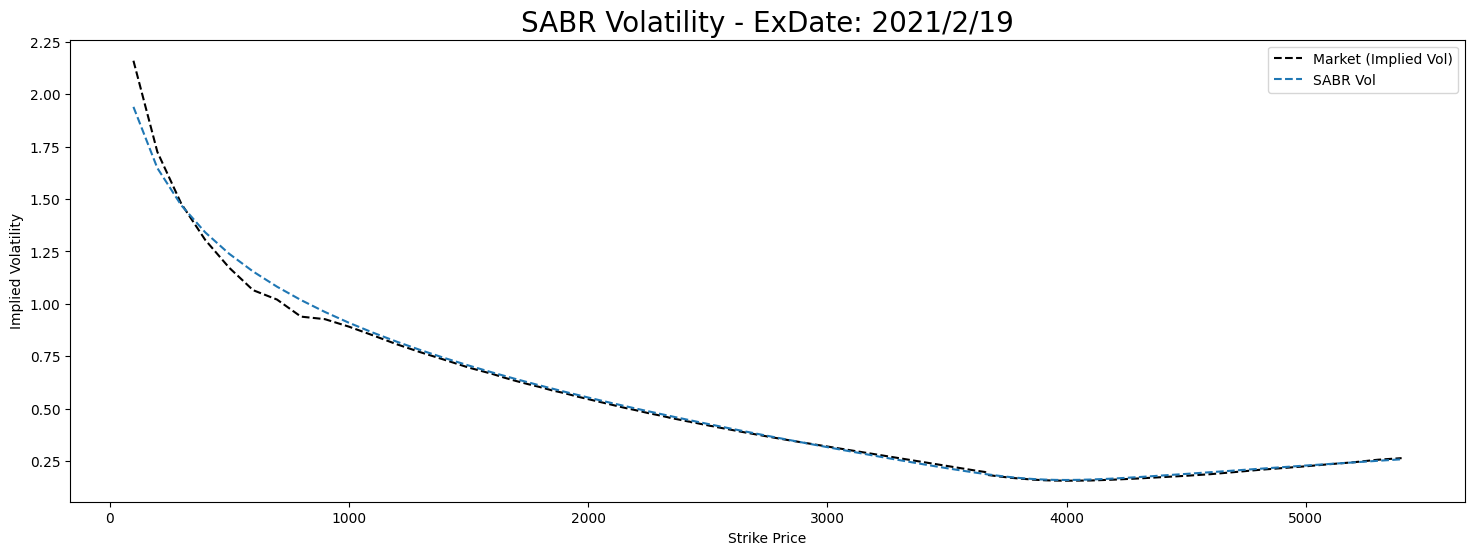

In [47]:
plt.figure(figsize=(18 , 6))
plt.plot(dd_3['strike'], dd_3['impliedvol_market'], 'k--', label='Market (Implied Vol)')
sns.lineplot(x = dd_3['strike'], y = SABR3, label = 'SABR Vol', linestyle = '--')


plt.title('SABR Volatility - ExDate: 2021/2/19', fontsize = 20)
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')

plt.legend()
plt.show()